In [ ]:
%%configure
{
    "conf":{
        "spark.pyspark.virtualenv.enabled": "false"
    }
}

In [1]:
# Import local libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time

# Import GeoPandas
import geopandas as gpd

# Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DoubleType, FloatType
from pyspark.sql.functions import col

# Import Apache Sedona
from sedona.register import SedonaRegistrator
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.utils.adapter import Adapter as adp

## Define spark session if not defined yet
No need to define spark if run in an external cloud

In [2]:
try:
    spark
except NameError:
    spark = SparkSession. \
    builder. \
    appName('appName'). \
    master('local[*]'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/09 10:01:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")
sc._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")

def delete_path(sc, path):
    fs = (sc._jvm.org
          .apache.hadoop
          .fs.FileSystem
          .get(sc._jsc.hadoopConfiguration())
          )
    fs.delete(sc._jvm.org.apache.hadoop.fs.Path(path), True)

## Use the prefix in all your EMR path

If you use EMR, EMR requires that all paths must be relative. Please use the variable below as the prefix for all paths because it can automatically detect if you are in Wherobots environment or not.

In [4]:
from pathlib import Path

PATH_PREFIX= str(Path.home()) + '/' if os.environ.get('ENV_WB', 'false') == 'true' else ''

print(PATH_PREFIX)

/home/wherobots/


## Load Taxi Pick Up Data to Sedona

In [5]:
zones_rdd = ShapefileReader.readToGeometryRDD(sc, "s3a://wherobots-examples/data/pickup_data/shape_file")
zones_df = adp.toDf(zones_rdd, spark)
zones_df = zones_df.drop("_id")
zones_df = zones_df.rdd.zipWithIndex().toDF()
zones_df = zones_df.select(col("_1.*"), col("_2").alias('ids'))
zones_df = zones_df.withColumn("pickup_count", zones_df.pickup_cou.cast(IntegerType())).drop("pickup_cou")
zones_df.show(5)

23/02/09 10:01:31 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


+--------------------+---+------------+
|            geometry|ids|pickup_count|
+--------------------+---+------------+
|POLYGON ((-74.184...|  0|          92|
|MULTIPOLYGON (((-...|  1|          19|
|POLYGON ((-73.847...|  2|           7|
|POLYGON ((-73.971...|  3|        4519|
|POLYGON ((-74.174...|  4|           2|
+--------------------+---+------------+
only showing top 5 rows



## Perform Spatially Constrained Hierarchical Clustering
Cluster the spatial zones hierarchically based on spatial contiguity and attribute similarity. We perform the clustering on the attribute pickup_count. More attributes can also be used.

In [6]:
from lampy import SCH_Clustering
from lampy import SparkRegistration

SparkRegistration.set_spark_session(spark)

In [7]:
clustered_df = SCH_Clustering.fit(zones_df, ["pickup_count"], "geometry", "ids", 10)
clustered_df.show(10)

23/02/09 10:01:41 WARN JoinQuery: UseIndex is true, but no index exists. Will build index on the fly.


+--------------------+---+------------+-------------+
|            geometry|ids|pickup_count|cluster_label|
+--------------------+---+------------+-------------+
|POLYGON ((-74.184...|  0|          92|            0|
|MULTIPOLYGON (((-...|  1|          19|            1|
|POLYGON ((-73.847...|  2|           7|            2|
|POLYGON ((-73.971...|  3|        4519|            9|
|POLYGON ((-74.174...|  4|           2|            8|
|POLYGON ((-74.063...|  5|           2|            8|
|POLYGON ((-73.904...|  6|        2023|            7|
|POLYGON ((-73.923...|  7|          11|            7|
|POLYGON ((-73.785...|  8|          12|            7|
|POLYGON ((-73.783...|  9|         100|            7|
+--------------------+---+------------+-------------+
only showing top 10 rows



## Visualize the Spatially Constrained Clusters
We clustered all zones into a total of 10 clusterns

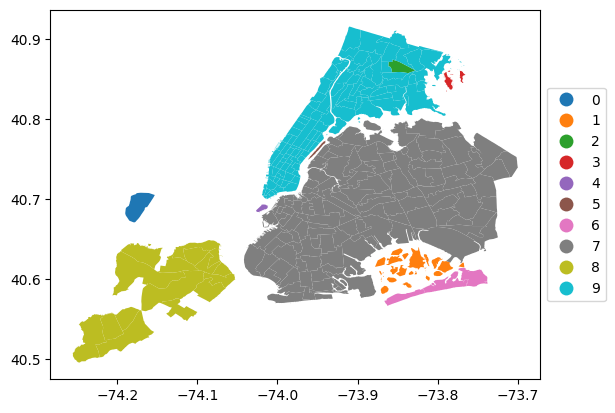

In [8]:
clustered_gdf = gpd.GeoDataFrame(clustered_df.toPandas(), geometry = "geometry", crs = "EPSG:4326")
ax = clustered_gdf.plot(column='cluster_label', categorical=True, aspect = 'equal', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})

In [ ]:
%matplot plt